## 5G NR Primary Synchronization Signal (PSS)  

### 1. Generate the m-sequence $x(i)$  

This is a binary sequence of length 127. It is produced using the relation:  

$$
x(i+7) = \bigl(x(i+4) + x(i)\bigr) \bmod 2
$$  

Initial state:  

$$
[x(6)\;x(5)\;x(4)\;x(3)\;x(2)\;x(1)\;x(0)] = [1, 1, 1, 0, 1, 1, 0]
$$  

(Here $x(0)$ is the LSB).  

#### Illustration of First Few $x(i)$ Values  

| i     | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | ... |
|-------|---|---|---|---|---|---|---|---|---|---|-----|
| x(i)  | 0 | 1 | 1 | 0 | 1 | 1 | 1 | 1 | 1 | 0 | ... |  

After the initial 7 bits, each new $x(i)$ is computed as:  

$$
x(i) = (x(i-3) + x(i-7)) \bmod 2
$$  

### 2. Compute $m(n)$  

For each $n = 0, 1, \dots, 126$:  

$$
m(n) = (n + 43 \cdot N_{ID}^{(2)}) \bmod 127
$$  

where $N_{ID}^{(2)} \in \{0, 1, 2\}$.  

### 3. Map to $d_{\text{PSS}}(n)$  

Finally, compute:  

$$
d_{\text{PSS}}(n) = 1 - 2 \cdot x\bigl(m(n)\bigr)
$$  

This maps:  

- $x(m(n)) = 0 \;\;\rightarrow\;\; d_{\text{PSS}}(n) = +1$  
- $x(m(n)) = 1 \;\;\rightarrow\;\; d_{\text{PSS}}(n) = -1$  

#### Illustration of Mapping to $d_{\text{PSS}}(n)$  

| n           | 0 | 1 | 2 | 3 | 4 | ... |
|-------------|---|---|---|---|---|-----|
| m(n)        | 0 | 1 | 2 | 3 | 4 | ... |
| x(m(n))     | 0 | 1 | 1 | 0 | 1 | ... |
| dPSS(n)     | +1| -1| -1| +1| -1| ... |  

This is a **BPSK-mapped sequence** that is transmitted as the Primary Synchronization Signal (PSS) in 5G NR as per TS 38.211 by 3GPP.  


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import py3gpp as gpp
import random

PSS Sequence:
 [ 1 -1 -1  1 -1 -1 -1 -1  1  1 -1 -1 -1  1  1 -1  1 -1  1 -1 -1  1  1 -1
 -1  1  1  1  1  1 -1 -1  1 -1 -1  1 -1  1 -1 -1 -1  1 -1  1  1  1 -1 -1
  1  1 -1  1  1  1 -1  1  1  1  1  1  1 -1  1  1 -1  1  1 -1 -1  1 -1  1
  1 -1 -1 -1 -1  1 -1 -1 -1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1
 -1 -1  1 -1 -1  1  1  1 -1  1 -1  1  1 -1  1 -1 -1 -1 -1 -1  1 -1  1 -1
  1 -1  1  1  1  1 -1]
PSS Indices:
 [ 56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182]


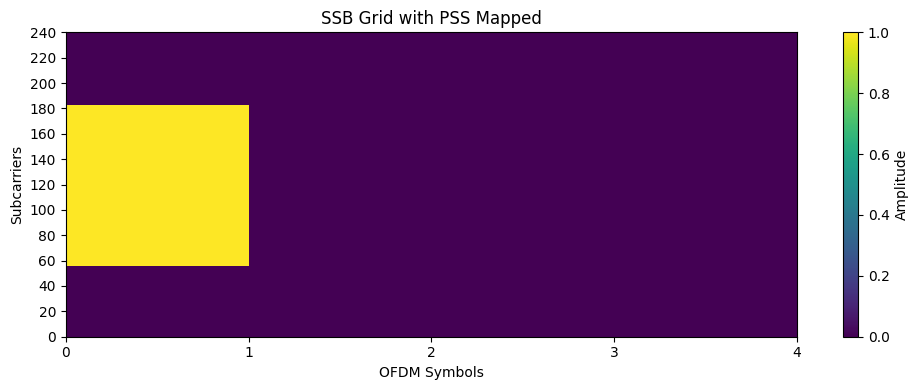

In [11]:
# -------------------------------
# Generate PSS sequence and indices
# -------------------------------
NID2 = 0  # Cell-specific ID for PSS
pss_seq = gpp.nrPSS(NID2)
pss_indices = gpp.nrPSSIndices()

print("PSS Sequence:\n", pss_seq)
print("PSS Indices:\n", pss_indices)

# -------------------------------
# Create empty SSB grid
# -------------------------------
num_subcarriers = 240
num_ofdm_symbols = 4
ssb_grid = np.zeros((num_subcarriers, num_ofdm_symbols), dtype=complex)

# Map PSS to the first OFDM symbol (symbol 0)
ssb_grid[pss_indices, 0] = pss_seq

# -------------------------------
# Visualize the SSB grid
# -------------------------------
plt.figure(figsize=(10, 4))
plt.pcolormesh(np.abs(ssb_grid), shading='auto', cmap='viridis')
plt.colorbar(label="Amplitude")
plt.title("SSB Grid with PSS Mapped")
plt.xlabel("OFDM Symbols")
plt.ylabel("Subcarriers")
plt.xticks(np.arange(num_ofdm_symbols+0.1))
plt.yticks(np.arange(0, num_subcarriers+0.1, 20))
plt.tight_layout()
plt.show()


## 5G NR Secondary Synchronization Signal (SSS)

### 1. Compute m₀ and m₁

First, compute the cyclic shift parameters m₀ and m₁ using:

$$
m_0 = 15 \cdot \left\lfloor \frac{N_{ID}^{(1)}}{112} \right\rfloor + 5 \cdot N_{ID}^{(2)}
$$

$$
m_1 = N_{ID}^{(1)} \bmod 112
$$

where:

- \(N_{ID}^{(1)} \in [0, 335]\) → Cell ID group index  
- \(N_{ID}^{(2)} \in [0, 2]\) → PSS index (same as used for PSS generation)

These define the cyclic shifts for x₀ and x₁.

### 2. Generate m-sequence x₀(i)

The first m-sequence x₀(i) is generated using:

$$
x_0(i+7) = \bigl(x_0(i) + x_0(i+4)\bigr) \bmod 2
$$

Initial state:

$$
[x_0(6)\;x_0(5)\;x_0(4)\;x_0(3)\;x_0(2)\;x_0(1)\;x_0(0)] = [0, 0, 0, 0, 0, 0, 1]
$$

(Here x₀(0) is the LSB)

### 3. Generate m-sequence x₁(i)

The second m-sequence x₁(i) uses a slightly different recurrence:

$$
x_1(i+7) = \bigl(x_1(i+1) + x_1(i)\bigr) \bmod 2
$$

with the same initial state as x₀:

$$
[x_1(6)\;x_1(5)\;x_1(4)\;x_1(3)\;x_1(2)\;x_1(1)\;x_1(0)] = [0, 0, 0, 0, 0, 0, 1]
$$

### 4. Compute m₀(n) and m₁(n)

For each \(n = 0, 1, \dots, 126\):

$$
m_0(n) = (n + m_0) \bmod 127
$$

$$
m_1(n) = (n + m_1) \bmod 127
$$

### 5. Generate dSSS(n)

Finally, the SSS sequence is computed as:

$$
dSSS(n) = \bigl(1 - 2 \cdot x_0(m_0(n))\bigr) \cdot \bigl(1 - 2 \cdot x_1(m_1(n))\bigr)
$$

This performs BPSK mapping, where:

- x₀(m₀(n)), x₁(m₁(n)) = 0 → contributes +1  
- x₀(m₀(n)), x₁(m₁(n)) = 1 → contributes −1

### Illustration of Mapping to dSSS(n)

| n        | 0  | 1  | 2  | 3  | 4  | ... |
|---------|----|----|----|----|----|-----|
| m₀(n)   | 0  | 1  | 2  | 3  | 4  | ... |
| x₀(m₀)  | 1  | 0  | 0  | 1  | 1  | ... |
| m₁(n)   | 0  | 1  | 2  | 3  | 4  | ... |
| x₁(m₁)  | 0  | 1  | 0  | 1  | 0  | ... |
| dSSS(n) | −1 | −1 | +1 | +1 | −1 | ... |

This results in a 127-length BPSK-mapped sequence that carries the cell ID group information. Together with the PSS, it uniquely identifies a 5G NR cell’s physical cell identity:

$$
PCI = 3 \cdot N_{ID}^{(1)} + N_{ID}^{(2)}
$$


SSS Sequence:
 [-1  1 -1  1  1 -1  1 -1 -1 -1  1 -1  1 -1  1 -1 -1 -1  1  1 -1  1  1  1
  1 -1  1  1  1 -1 -1  1 -1  1  1 -1 -1  1  1  1 -1  1 -1 -1  1  1  1  1
  1  1  1 -1  1  1  1 -1  1  1 -1  1 -1 -1  1 -1  1  1  1  1  1 -1  1  1
 -1  1  1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1  1 -1 -1 -1 -1 -1  1 -1 -1
  1 -1 -1 -1 -1 -1  1 -1  1  1  1  1  1  1 -1 -1 -1  1 -1  1  1 -1 -1 -1
  1 -1  1 -1 -1 -1 -1]
SSS Indices (adjusted):
 [ 56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182]


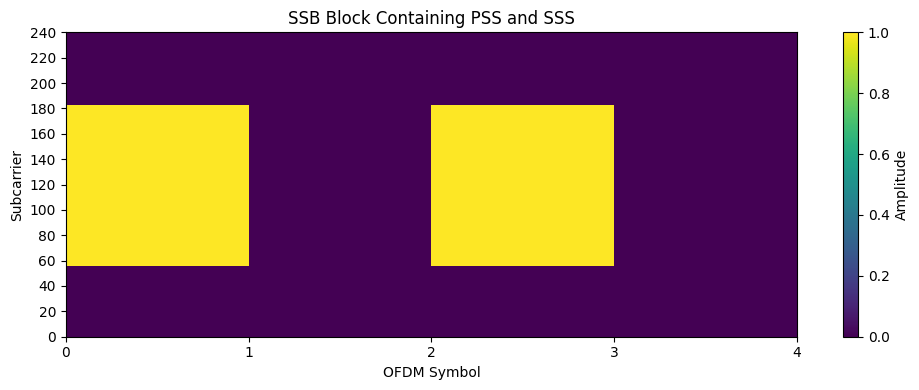

In [12]:
# -------------------------------
# Generate SSS sequence and indices
# -------------------------------
NID1 = 1  # Example value for NID1
sss_seq = gpp.nrSSS(NID1)
sss_indices = gpp.nrSSSIndices()

# Adjust indices to fit the 240-subcarrier grid
sss_indices = sss_indices - 480  

print("SSS Sequence:\n", sss_seq)
print("SSS Indices (adjusted):\n", sss_indices)

# -------------------------------
# Map SSS to the SSB grid
# -------------------------------
# Assuming ssb_grid already exists with shape (240, 4) from PSS mapping
# Map SSS to the third OFDM symbol (symbol index 2)
ssb_grid[sss_indices, 2] = sss_seq

# -------------------------------
# Visualize the SSB grid with PSS and SSS
# -------------------------------
plt.figure(figsize=(10, 4))
plt.pcolormesh(np.abs(ssb_grid), shading='auto', cmap='viridis')
plt.colorbar(label="Amplitude")
plt.title("SSB Block Containing PSS and SSS")
plt.xlabel("OFDM Symbol")
plt.ylabel("Subcarrier")
plt.xticks(np.arange(ssb_grid.shape[1]+0.1))
plt.yticks(np.arange(0, ssb_grid.shape[0]+0.1, 20))
plt.tight_layout()
plt.show()


## PBCH Payload

PBCH carries the Master Information Block (MIB). In the 3GPP standard, the short MIB payload is CRC-appended, then polar coded and rate-matched into an 864-bit codeword that is finally QPSK-mapped and placed across the PBCH REs inside the SSB.

PBCH modulation consists of the following steps:

### 1. Scrambling

Bits are scrambled according to:

$\bar{b}(i) = \bigl(b(i) + c(i + v M_{\text{bit}})\bigr) \bmod 2$

where:

- $b(i)$ = input bit sequence  
- $c(i)$ = scrambling sequence as defined in 3GPP TS 38.211  
- $M_{\text{bit}}$ = number of bits transmitted on the physical broadcast channel

### 2. Modulation

The scrambled bits $\bar{b}(i)$ are QPSK modulated as per 3GPP TS 38.211.

### 3. Mapping

PBCH is mapped across time/frequency as follows:

- OFDM symbol 1 → subcarriers $k = 0 \dots 239$  
- OFDM symbol 3 → subcarriers $k = 0 \dots 239$  
- OFDM symbol 2 → edge ranges $k = 0 \dots 47$ and $k = 192 \dots 239$

Some REs within those symbols are reserved for PBCH DM-RS (pilot REs).


PBCH:
 [-0.70710678+0.70710678j  0.70710678-0.70710678j  0.70710678-0.70710678j
 -0.70710678-0.70710678j  0.70710678-0.70710678j  0.70710678+0.70710678j
  0.70710678+0.70710678j  0.70710678+0.70710678j -0.70710678-0.70710678j
  0.70710678-0.70710678j -0.70710678+0.70710678j -0.70710678-0.70710678j
  0.70710678+0.70710678j -0.70710678+0.70710678j -0.70710678-0.70710678j
 -0.70710678+0.70710678j -0.70710678+0.70710678j -0.70710678-0.70710678j
 -0.70710678+0.70710678j -0.70710678-0.70710678j  0.70710678-0.70710678j
  0.70710678-0.70710678j  0.70710678+0.70710678j -0.70710678+0.70710678j
  0.70710678-0.70710678j -0.70710678-0.70710678j -0.70710678+0.70710678j
 -0.70710678+0.70710678j -0.70710678+0.70710678j  0.70710678+0.70710678j
 -0.70710678+0.70710678j -0.70710678-0.70710678j -0.70710678-0.70710678j
  0.70710678-0.70710678j -0.70710678-0.70710678j  0.70710678-0.70710678j
 -0.70710678-0.70710678j  0.70710678+0.70710678j -0.70710678-0.70710678j
 -0.70710678-0.70710678j -0.70710678+0.70710

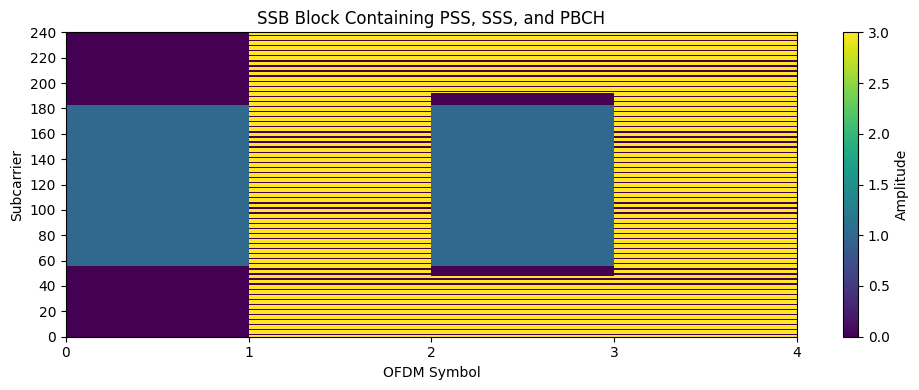

In [13]:
# -------------------------------
# Generate PBCH sequence
# -------------------------------
codeword = np.random.randint(0, 2, size=(864,), dtype=np.uint8)
v = 0
NcellID = 1

pbch = gpp.nrPBCH(NcellID, v, codeword)
print("PBCH:\n", pbch)
print("PBCH shape:", pbch.shape)

pbch_indices = gpp.nrPBCHIndices(NcellID)
print("PBCH Indices:\n", pbch_indices)

# -------------------------------
# Map PBCH to SSB grid
# -------------------------------
# Symbol 1 (second OFDM symbol, index 1)
symbol1_indices = pbch_indices[(pbch_indices > 239) & (pbch_indices < 480)] % 240
symbol1_count = len(symbol1_indices)
ssb_grid[symbol1_indices, 1] = 3 * pbch[0:symbol1_count]

print("Symbol 1 PBCH Indices:\n", symbol1_indices)
print("Number of REs in Symbol 1:", symbol1_count)

# Symbol 3 (fourth OFDM symbol, index 3)
symbol3_indices = pbch_indices[pbch_indices >= 720] % 240
symbol3_count = len(symbol3_indices)
ssb_grid[symbol3_indices, 3] = 3 * pbch[-180:]

print("Symbol 3 PBCH Indices:\n", symbol3_indices)
print("Number of REs in Symbol 3:", symbol3_count)

# Symbol 2 (third OFDM symbol, index 2)
symbol2_indices = pbch_indices[(pbch_indices >= 480) & (pbch_indices < 720)] % 240
symbol2_count = len(symbol2_indices)
ssb_grid[symbol2_indices, 2] = 3 * pbch[180:len(pbch)-180]

print("Symbol 2 PBCH Indices:\n", symbol2_indices)
print("Number of REs in Symbol 2:", symbol2_count)

# -------------------------------
# Visualize SSB grid with PSS, SSS, and PBCH
# -------------------------------
plt.figure(figsize=(10, 4))
plt.pcolormesh(np.abs(ssb_grid), shading='auto', cmap='viridis')
plt.colorbar(label="Amplitude")
plt.title("SSB Block Containing PSS, SSS, and PBCH")
plt.xlabel("OFDM Symbol")
plt.ylabel("Subcarrier")
plt.xticks(np.arange(ssb_grid.shape[1]+0.1))
plt.yticks(np.arange(0, ssb_grid.shape[0]+0.1, 20))
plt.tight_layout()
plt.show()


## PBCH-DMRS

DMRS is a 144-symbol sequence (per SSB) that depends on the Cell ID and the time index part $\bar{i}_{SSB}$.  

The UE shall assume the reference-signal sequence $r(m)$ for an SSB is defined by

$$
r(m) = \frac{1}{\sqrt{2}} \Bigl[ \bigl(1 - 2 \cdot c(2m)\bigr) + j \cdot \bigl(1 - 2 \cdot c(2m + 1)\bigr) \Bigr]
$$

where $c(n)$ is the scrambling sequence.


PBCH DMRS Indices:
 [241 245 249 253 257 261 265 269 273 277 281 285 289 293 297 301 305 309
 313 317 321 325 329 333 337 341 345 349 353 357 361 365 369 373 377 381
 385 389 393 397 401 405 409 413 417 421 425 429 433 437 441 445 449 453
 457 461 465 469 473 477 481 485 489 493 497 501 505 509 513 517 521 525
 673 677 681 685 689 693 697 701 705 709 713 717 721 725 729 733 737 741
 745 749 753 757 761 765 769 773 777 781 785 789 793 797 801 805 809 813
 817 821 825 829 833 837 841 845 849 853 857 861 865 869 873 877 881 885
 889 893 897 901 905 909 913 917 921 925 929 933 937 941 945 949 953 957]
Symbol 1 PBCH DMRS Indices:
 [  1   5   9  13  17  21  25  29  33  37  41  45  49  53  57  61  65  69
  73  77  81  85  89  93  97 101 105 109 113 117 121 125 129 133 137 141
 145 149 153 157 161 165 169 173 177 181 185 189 193 197 201 205 209 213
 217 221 225 229 233 237]
Number of REs in Symbol 1: 60
Symbol 3 PBCH DMRS Indices:
 [  1   5   9  13  17  21  25  29  33  37  41  45  49  53  57  

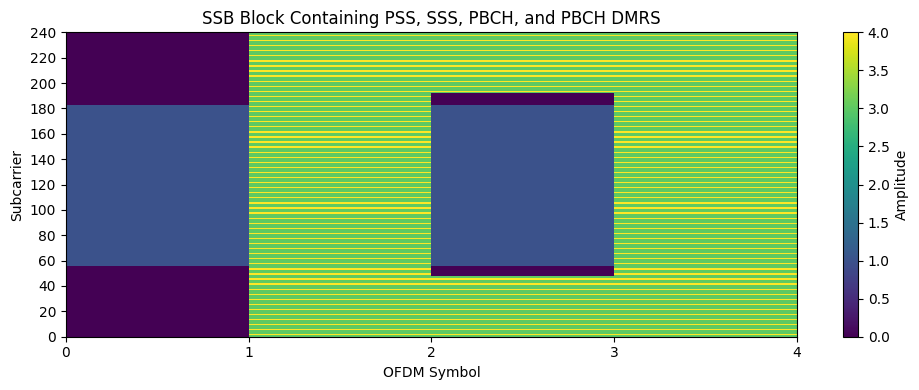

In [14]:
# -------------------------------
# 1. Generate PBCH-DMRS
# -------------------------------
ibar_ssb = 0
pbch_dmrs = 4 * gpp.nrPBCHDMRS(NcellID, ibar_ssb)  # scale factor

pbch_dmrs_indices = gpp.nrPBCHDMRSIndices(NcellID)
print("PBCH DMRS Indices:\n", pbch_dmrs_indices)

# -------------------------------
# 2. Map PBCH-DMRS to SSB grid
# -------------------------------

# Symbol 1 (second OFDM symbol, index 1)
symbol1_indices = pbch_dmrs_indices[(pbch_dmrs_indices > 239) & (pbch_dmrs_indices < 480)] % 240
symbol1_count = len(symbol1_indices)
ssb_grid[symbol1_indices, 1] = pbch_dmrs[0:symbol1_count]

print("Symbol 1 PBCH DMRS Indices:\n", symbol1_indices)
print("Number of REs in Symbol 1:", symbol1_count)

# Symbol 3 (fourth OFDM symbol, index 3)
symbol3_indices = pbch_dmrs_indices[pbch_dmrs_indices >= 720] % 240
symbol3_count = len(symbol3_indices)
ssb_grid[symbol3_indices, 3] = pbch_dmrs[-symbol3_count:]

print("Symbol 3 PBCH DMRS Indices:\n", symbol3_indices)
print("Number of REs in Symbol 3:", symbol3_count)

# Symbol 2 (third OFDM symbol, index 2)
symbol2_indices = pbch_dmrs_indices[(pbch_dmrs_indices >= 480) & (pbch_dmrs_indices < 720)] % 240
symbol2_count = len(symbol2_indices)
ssb_grid[symbol2_indices, 2] = pbch_dmrs[symbol1_count:len(pbch_dmrs)-symbol1_count]

print("Symbol 2 PBCH DMRS Indices:\n", symbol2_indices)
print("Number of REs in Symbol 2:", symbol2_count)

# -------------------------------
# 3. Visualize SSB grid with all components
# -------------------------------
plt.figure(figsize=(10, 4))
plt.pcolormesh(np.abs(ssb_grid), shading='auto', cmap='viridis')
plt.colorbar(label="Amplitude")
plt.title("SSB Block Containing PSS, SSS, PBCH, and PBCH DMRS")
plt.xlabel("OFDM Symbol")
plt.ylabel("Subcarrier")
plt.xticks(np.arange(ssb_grid.shape[1]+0.1))
plt.yticks(np.arange(0, ssb_grid.shape[0]+0.1, 20))
plt.tight_layout()
plt.show()


## SS Burst  

An SS burst is composed of multiple SSBs and occupies half of a radio frame, which corresponds to five subframes.  

### Frame and Slot Structure (TS 38.211 §4.3.1)  

- One frame = 10 subframes (each of 1 ms).  
- One slot = 14 OFDM symbols (for normal CP).  
- The number of slots per subframe depends on the subcarrier spacing (SCS).  

### Subcarrier Spacing  

Subcarrier spacing is defined by the numerology $\mu$:  

$$
\text{SCS} = 15 \,\text{kHz} \cdot 2^{\mu}
$$  

Example:  
- For $\mu = 1$, $\text{SCS} = 30 \,\text{kHz}$.  

### Total Number of OFDM Symbols in an SS Burst  

The number of OFDM symbols contained in an SS burst is:  

$$
N_{\text{symbols}} = (\text{symbols per slot}) \cdot 2^{\mu} \cdot N_{\text{subframes}}
$$  

For $\mu = 1$, $\text{symbols per slot} = 14$, $N_{\text{subframes}} = 5$:  

$$
N_{\text{symbols}} = 14 \cdot 2^{1} \cdot 5 = 140
$$  


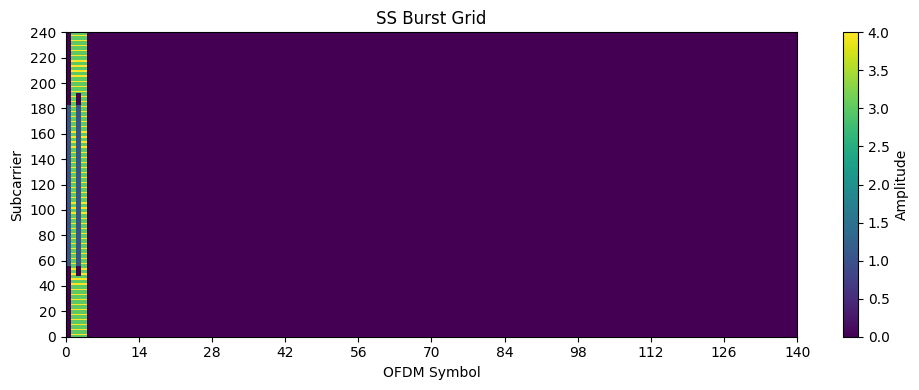

In [15]:
# -------------------------------
# 1. SS Burst Grid Parameters
# -------------------------------
n_subframes = 5
symbols_per_slot = 14
mu = 1  # SCS configuration
n_symbols = n_subframes * symbols_per_slot * (2**mu)

# Create SS burst grid
ssburst_grid = np.zeros((240, n_symbols), dtype=complex)

# Map the SSB grid to the first 4 OFDM symbols
ssburst_grid[:, 0:4] = ssb_grid

# -------------------------------
# 2. Visualize SS Burst Grid
# -------------------------------
plt.figure(figsize=(10, 4))
plt.pcolormesh(np.abs(ssburst_grid), shading='auto', cmap='viridis')
plt.colorbar(label="Amplitude")
plt.title("SS Burst Grid")
plt.xlabel("OFDM Symbol")
plt.ylabel("Subcarrier")
plt.xticks(np.arange(0, n_symbols+0.1, 14))  # mark each slot
plt.yticks(np.arange(0, 240+0.1, 20))
plt.tight_layout()
plt.show()


## SSB Pattern Inside the SS Burst  

There are seven block patterns (Case A – Case G), which differ in subcarrier spacing (SCS) and are applicable for different carrier frequency ranges. The maximum number of SSBs per half frame depends on the operating frequency band.  

### Time Location of SSB  

The maximum number of beams ($L_{\text{max}}$) depends on the operating band:  

- $\text{Op. Band} \leq 3 \,\text{GHz} \;\;\Rightarrow\;\; L_{\text{max}} = 4$  
- $3 \,\text{GHz} \leq \text{Op. Band} \leq 6 \,\text{GHz} \;\;\Rightarrow\;\; L_{\text{max}} = 8$  
- $\text{Op. Band} > 6 \,\text{GHz} \;\;\Rightarrow\;\; L_{\text{max}} = 64$  

Each beam transmits one SSB, and each beam is identified by an SS block index.  

### Block Patterns in FR1 (Sub-6 GHz)  

Here, $L_{\text{max}} = 4 \text{ or } 8$.  

- Case A – 15 kHz SCS  
  - SSB locations: 2, 8, 16, 22  
  - OFDM symbols:  
    - SSB at index 2 → symbols 2,3,4,5  
    - SSB at index 8 → symbols 8,9,10,11  
    - SSB at index 16 → symbols 16,17,18,19  
    - SSB at index 22 → symbols 22,23,24,25  

- Case B – 30 kHz SCS  
  - SSB locations: 4, 8, 16, 20  

- Case C – 30 kHz SCS  
  - SSB locations: 2, 8, 16, 22  

### Block Patterns in FR2 (Above 6 GHz, mmWave)  

Here, $L_{\text{max}} = 64$.  

- Case D – 120 kHz SCS  
  - SSB locations: 2, 8, 16, 20  

- Case E – 240 kHz SCS  
  - SSB locations: 8, 12, 16, 20  

- Case F – 480 kHz SCS  
  - SSB locations: Defined in 3GPP TS 38.211  

- Case G – 960 kHz SCS  
  - SSB locations: Defined in 3GPP TS 38.211  

### Frequency Location of SSB  

The SSB frequency position can be shifted anywhere in frequency, controlled by two parameters:  

1. Offset to Point A (in PRBs):  
   - 15 kHz in FR1  
   - 60 kHz in FR2  

2. Subcarrier offset ($k_{\text{SSB}}$):  
   - 15 kHz in FR1  
   - 60 kHz or 120 kHz in FR2  

By adjusting the offset to Point A and $k_{\text{SSB}}$, the SSB can be placed flexibly across the carrier bandwidth.  


## SSB pattern for Case B

It has Lmax=8 blocks per burst

In [16]:
def map_pbch_to_ssb_grid(pbch, pbch_indices, ssb_grid):
    num_subcarriers = ssb_grid.shape[0]       # Typically 240 for NR SSB
    num_symbols = ssb_grid.shape[1]           # Typically 4 for NR SSB

    # Calculate start/end boundaries dynamically
    boundary1 = num_subcarriers * 1          # 240
    boundary2 = num_subcarriers * 2          # 480
    boundary3 = num_subcarriers * 3          # 720

    # Symbol 1 (second OFDM symbol, index 1)
    symbol1_indices = pbch_indices[(pbch_indices >= boundary1) & (pbch_indices < boundary2)] % num_subcarriers
    symbol1_count = len(symbol1_indices)
    ssb_grid[symbol1_indices, 1] = 3 * pbch[0:symbol1_count]

    # Symbol 3 (fourth OFDM symbol, index 3)
    symbol3_indices = pbch_indices[pbch_indices >= boundary3] % num_subcarriers
    symbol3_count = len(symbol3_indices)
    ssb_grid[symbol3_indices, 3] = 3 * pbch[-symbol3_count:]

    # Symbol 2 (third OFDM symbol, index 2)
    symbol2_indices = pbch_indices[(pbch_indices >= boundary2) & (pbch_indices < boundary3)] % num_subcarriers
    symbol2_count = len(symbol2_indices)
    ssb_grid[symbol2_indices, 2] = 3 * pbch[symbol1_count:len(pbch)-symbol3_count]

    return ssb_grid

def map_pbch_dmrs_to_ssb_grid(pbch_dmrs, pbch_dmrs_indices, ssb_grid):
    num_subcarriers = ssb_grid.shape[0]       # Typically 240 for NR SSB
    num_symbols = ssb_grid.shape[1]           # Typically 4 for NR SSB

    # Calculate start/end boundaries dynamically
    boundary1 = num_subcarriers * 1          # 240
    boundary2 = num_subcarriers * 2          # 480
    boundary3 = num_subcarriers * 3          # 720

    # Symbol 1 (second OFDM symbol, index 1)
    symbol1_indices = pbch_dmrs_indices[(pbch_dmrs_indices >= boundary1) & (pbch_dmrs_indices < boundary2)] % num_subcarriers
    symbol1_count = len(symbol1_indices)
    ssb_grid[symbol1_indices, 1] = pbch_dmrs[0:symbol1_count]

    # Symbol 3 (fourth OFDM symbol, index 3)
    symbol3_indices = pbch_dmrs_indices[pbch_dmrs_indices >= boundary3] % num_subcarriers
    symbol3_count = len(symbol3_indices)
    ssb_grid[symbol3_indices, 3] = pbch_dmrs[-symbol3_count:]

    # Symbol 2 (third OFDM symbol, index 2)
    symbol2_indices = pbch_dmrs_indices[(pbch_dmrs_indices >= boundary2) & (pbch_dmrs_indices < boundary3)] % num_subcarriers
    symbol2_count = len(symbol2_indices)    
    ssb_grid[symbol2_indices, 2] = pbch_dmrs[symbol1_count:len(pbch_dmrs)-symbol3_count]
    return ssb_grid




[ 4  8 16 20 32 36 44 48]


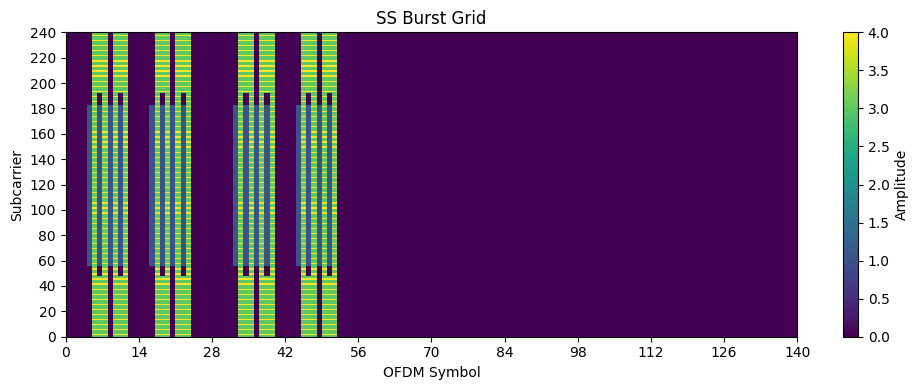

In [17]:
n = np.array([0, 1])
first_symbol_index = np.array([4, 8, 16, 20])[:, None] + 28 * n  # column vector + row vector
first_symbol_index = first_symbol_index.flatten(order='F')  # make it a 1D array
print(first_symbol_index)


ssb_grid = np.zeros((240, 4), dtype=complex)
ssb_grid[pss_indices, 0] = pss_seq
ssb_grid[sss_indices, 2] = sss_seq

ssburst_grid.fill(0)  # reset the SS burst grid

for ssb_index in range(len(first_symbol_index)):

    i_ssb = (ssb_index-1)%8
    ibar_ssb = i_ssb
    v = i_ssb

    pbch_symbol = gpp.nrPBCH(NcellID, v, codeword)
    pbch_indices = gpp.nrPBCHIndices(NcellID)
    ssb_grid = map_pbch_to_ssb_grid(pbch_symbol, pbch_indices, ssb_grid)

    pbch_dmrs = 4 * gpp.nrPBCHDMRS(NcellID, ibar_ssb)  # scale factor
    pbch_dmrs_indices = gpp.nrPBCHDMRSIndices(NcellID)  
    ssb_grid = map_pbch_dmrs_to_ssb_grid(pbch_dmrs, pbch_dmrs_indices, ssb_grid)

    ssburst_grid[:, first_symbol_index[ssb_index] : first_symbol_index[ssb_index] + 4] = ssb_grid

# -------------------------------
# 2. Visualize SS Burst Grid
# -------------------------------
plt.figure(figsize=(10, 4))
plt.pcolormesh(np.abs(ssburst_grid), shading='auto', cmap='viridis')
plt.colorbar(label="Amplitude")
plt.title("SS Burst Grid")
plt.xlabel("OFDM Symbol")
plt.ylabel("Subcarrier")
plt.xticks(np.arange(0, n_symbols+0.1, 14))  # mark each slot
plt.yticks(np.arange(0, 240+0.1, 20))
plt.tight_layout()
plt.show()
